# Download Pushshift Reddit Data
See this on [Github](https://github.com/yinleon/doppler_tutorials/blob/master/1-download-data.ipynb), [NbViewer](https://nbviewer.jupyter.org/github/yinleon/doppler_tutorials/blob/master/1-download-data.ipynb)<br>
By Leon Yin 2019-04-05<br>
This Notebook collects subreddit metadata from PushShift's REST API, and downloads images from Reddit using requests.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import warnings

import pandas as pd
from tqdm import tqdm

import config
import context_manager
import doppler.data_sources.pushshift as ps
from doppler.image_utils import download_media_and_return_dhash, read_image

warnings.filterwarnings('ignore')

A trick in data engineering is creating a dictionary (called the _context_) that defines the destination of all output files. Here we illustrate an example of what it looks like:

In [3]:
def get_subbreddit_context(subreddit):
    '''
    Where will data be saved?
    '''
    sub_dir = os.path.join(config.data_dir, subreddit)
    media_dir =  os.path.join(config.data_dir, 'media')
    file_subreddit = os.path.join(sub_dir, 'posts.csv.gz')
    file_subreddit_media = os.path.join(sub_dir, 'media.csv.gz')
    
    for _dir in [config.data_dir, sub_dir, media_dir]:
        os.makedirs(_dir, exist_ok=True)
        
    context = {
        'data_dir' : config.data_dir,
        'sub_dir' : sub_dir,
        'media_dir' : media_dir,
        'file_subreddit' : file_subreddit,
        'file_subreddit_media' : file_subreddit_media
    }
    
    return context

 We will use functions like `get_subreddit_context` throughout this article. Rather than define these within each notebook, they are all writtein in the `context_manager.py` file.

## Query PushShift
Pushshift has an open restful API that returns JSON records. 

For your convenience, we have written a simple Python wrapper found in in `doppler/data_sources/pushshift.py`.

In [15]:
??ps.download_subreddit_posts

Signature:
ps.download_subreddit_posts(
    ['subreddit', 'size=5000', 'ascending=False', 'start_date=False', 'seen_ids=set()', 'display_every_x_iterations=20', 'verbose=True'],
)
Source:   
def download_subreddit_posts(subreddit, size=5000, ascending=False, 
                             start_date=False, seen_ids=set(), 
                             display_every_x_iterations=20,
                             verbose=True):
    '''
    Queries the pushshift.io API for a given `subreddit`.
    
    To go back in time from `start_date`, set ascending to False.
    To go forward from time `state_date`, set ascneding to True.
    Skips ids in set `seen_ids`.
    Displays the http request every `display_every_x_iterations` if `verbose`=True.
    '''
    if not isinstance(seen_ids, set):
        raise "seen_ids needs to be a set!"
    i = 0
    records = []
    last_record_date = start_date
    try:
        while True:
            # Buld the url
            url = build_api_endpoint(subreddit

<hr>
Note:<br>
The Jupyter Notebooks used throughout this article differ a bit from what you might expec. We are making a change by defining code in external Python scripts, rather than in the notebook itself. We do this because it makes the code easier to find and share, and allows notebooks to focus on commentary and explaination of moving parts.
<hr>

In [5]:
verbose = True
subreddit = config.subreddit # change this in config.py
context = get_subreddit_context(subreddit)

# check if the subreddit has already been collected
if os.path.exists(context['file_subreddit']):
    print('File Exists')
    df = pd.read_csv(context['file_subreddit'], 
                     compression='gzip')
    
    print(f'{ len(df) } Records exist')
    min_date = df.created_utc.min()
    max_date = df.created_utc.max()
    seen_ids = set(df.id.unique()) # these are records we've already collected
    
    # look for records that we haven't already collected
    newer_records = ps.download_subreddit_posts(subreddit, verbose=verbose, 
                                                seen_ids=seen_ids,
                                                ascending=True, 
                                                start_date=max_date)
    older_records = ps.download_subreddit_posts(subreddit, verbose=verbose, 
                                                seen_ids=seen_ids,
                                                ascending=False, 
                                                start_date=min_date)
    # append the new records to exists records, and save thme to disk
    newer_records.extend(older_records)
    _df = pd.DataFrame(newer_records)
    if verbose:
        print(f"collected { len(_df) } records")
    df = df.append(_df, sort=False)
    df.drop_duplicates(subset=['id'], inplace=True)
    df.sort_values(by=['created_utc'], ascending=False, inplace=True)
    df.to_csv(context['file_subreddit'], index=False, compression='gzip')

# if we've never colelcted the subreddit, we start a fresh query to download records.
else:
    print("New Subreddit")
    records = ps.download_subreddit_posts(subreddit, verbose=verbose, size=5000)
    if verbose:
        print(f"collected { len(records) } records")
    df = pd.DataFrame(records)
    df.to_csv(context['file_subreddit'], index=False, compression='gzip')

if verbose:
    # Summary stats
    print('\n****************')
    df['created_at'] = pd.to_datetime(df['created_utc'], unit='s')
    print(f"N = { len(df) }\n"
          f"Start Date = { df['created_at'].min() }\n"
          f"End Date = { df['created_at'].max() }")

File Exists


/home/chino/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,5,6,7,9,10,16,20,23,26,36,51,59,68,74,75,76,77,78,79,83,84,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1753411 Records exist
http://api.pushshift.io/reddit/submission/search/?subreddit=pewdiepiesubmissions&size=5000&after=1556398579&sort=asc
http://api.pushshift.io/reddit/submission/search/?subreddit=pewdiepiesubmissions&size=5000&after=1556741310&sort=asc
http://api.pushshift.io/reddit/submission/search/?subreddit=pewdiepiesubmissions&size=5000&before=1523373858&sort=desc
http://api.pushshift.io/reddit/submission/search/?subreddit=pewdiepiesubmissions&size=5000&before=1522322784&sort=desc
Cancelled early
collected 54266 records

****************
N = 1807677
Start Date = 2018-03-24 04:53:06
End Date = 2019-05-03 17:26:57


## Collect Images
After collecting the metadata for posts for our the subreddit of interest, we can download the media shared within the subreddit.
In this section, we filter the metadata for media, download all media from the open web, and calculate a fingerprint or _dhash_ of each image. More on dhashing [here](http://www.hackerfactor.com/blog/index.php?/archives/529-Kind-of-Like-That.html).

We created a high-level function called `download_media_and_return_dhash`, which uses the `requests` library to download an image locally, and `imagehash` to calculate the _dhash_.

In [11]:
??download_media_and_return_dhash

Signature: download_media_and_return_dhash(url, fn)
Source:   
def download_media_and_return_dhash(url, fn):
    '''
    Downloads a media file from the open web to local disk (if it does not exist yet).
    Calculates a dhash and the size of the file, and returns both as a tuple.
    If the download fails, returns a placeholder 'NOHASH' and a filezie of 0.
    '''
    if os.path.exists(fn):
        # is th image exists, don't download it again.
        # calculate the size and hash
        img_size = os.path.getsize(fn)
        if img_size != 0:
            # read the image and calculate the hash
            img = read_image(fn)
            dhash = str(imagehash.dhash(img, hash_size=8))
            
            return dhash, img_size
    else:
        if download_media(url, fn):
            # calculate the hash
            img = read_image(fn)
            img_size = os.path.getsize(fn)
            dhash = str(imagehash.dhash(img, hash_size=8))

            return dhash, img_size
    


In [7]:
len(df)

1807677

In [8]:
# we're only interested in records with a media preview...
df_media = df[~df.preview.isnull()]
len(df_media)

In [26]:
# check if the file exists, and which media records have been downloaded
if os.path.exists(context['file_subreddit_media']):
    df_img_meta = pd.read_csv(context['file_subreddit_media'], 
                              compression='gzip')     
    abd = df_img_meta.id
    df_media = df_media[~df_media.id.isin(abd)]

# download new media files
img_meta = []
try:
    for _, row in tqdm(df_media.iterrows()):
        preview = row.get('preview')
        if isinstance(preview, dict):
            images = preview.get('images')
            if not images:
                continue
            for img in images:
                r = row.copy()
                img_url, f_img = context_manager.get_media_context(img, context)
                if not img_url:
                    continue
                d_hash, img_size = download_media_and_return_dhash(img_url, f_img)
                if img_size != 0:
                    r['deleted'] = False
                    r['d_hash'] = d_hash
                    r['f_img'] = f_img 
                    r['img_size'] = img_size
                else:
                    r['deleted'] = True
                    r['d_hash'] = d_hash
                    r['f_img'] = f_img 
                    r['img_size'] = img_size
                img_meta.append(r.to_dict())

except KeyboardInterrupt:
    if verbose:
        print("cancelled early!")
    pass


# append to existing records, if that exitst and write to a csv
if os.path.exists(context['file_subreddit_media']):               
    _df_img_meta = pd.DataFrame(img_meta)
    df_img_meta = df_img_meta.append(_df_img_meta,sort=False)
else:
    df_img_meta = pd.DataFrame(img_meta)
    
df_img_meta.to_csv(context['file_subreddit_media'], 
                   index=False, compression='gzip')     


0it [00:00, ?it/s]
1it [00:03,  3.71s/it]
3it [00:03,  2.62s/it]
7it [00:04,  1.85s/it]
10it [00:04,  1.31s/it]
13it [00:04,  1.07it/s]
15it [00:04,  1.49it/s]
17it [00:04,  2.06it/s]
19it [00:05,  2.22it/s]
21it [00:05,  2.98it/s]
21it [00:23,  2.98it/s]

In [28]:
len(df_img_meta)

551

Now that the images are downloaded, we can read them from disk:

In [33]:
f_img = df_img_meta.f_img.iloc[0]

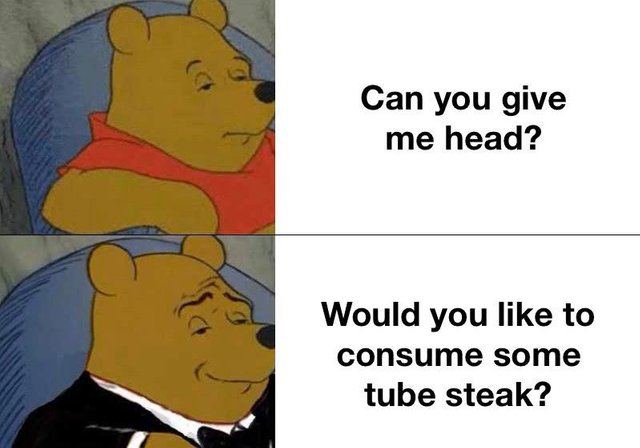

In [34]:
read_image(f_img)

Since we calculated the dhash of each image, we can count duplicates. Here are the most re-posted images:

In [10]:
most_shared_image_dhashes = df_img_meta[df_img_meta.d_hash != 'NOHASH'].d_hash.value_counts().head(20)
most_shared_image_dhashed

NameError: name 'df_img_meta' is not defined

In [43]:
most_posted_dhash = most_shared_image_dhashed.index[0]
most_posted_image_file = df_img_meta[df_img_meta.d_hash == most_posted_dhash].f_img.iloc[0]

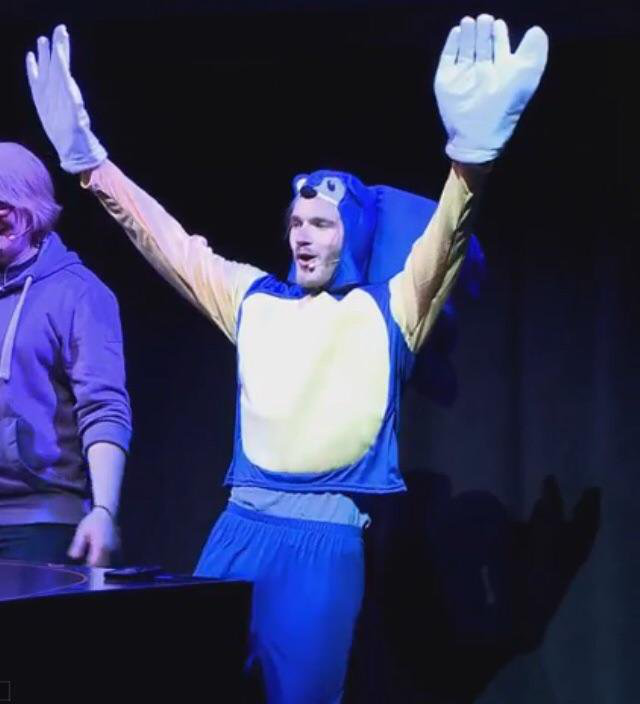

In [48]:
read_image(most_posted_image_file)